In [89]:
%config IPCompleter.use_jedi = False
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

%run -i 'model_helpers.py'

In [60]:
df = load_query_avg_data() # see data_helpers.py
df.head()

,querydetail,querytype,ID,estimate,coldrainy
0,cold,A,0,0.676667,1
1,windy,A,0,0.733333,0
2,cold and rainy,AandB,0,0.760000,1
3,windy and cloudy,AandB,0,0.773333,0
4,cold and not rainy,AandnotB,0,0.753333,1


In [61]:
X_data, y_data = make_model_data(df) # see data_helpers.py

# Bayesian sampler model

In [62]:
def bayesian_sampler_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        N_deltas = numpyro.sample("N_delta", dist.HalfNormal(50))
        N_primes = numpyro.sample("N_prime", dist.HalfNormal(50))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    # Model "guts"
    N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj # they required N be at least 1, no pooling for now
    
    beta = betas[subj]
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [35]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.80), 
               num_warmup=2000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [36]:
# mcmc_bs.print_summary()

In [37]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex, X_data) # see model_helpers.py
az.loo(az_data_bs, scale="deviance", pointwise=True)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -3457.09    85.80
p_loo          496.19        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3249   96.7%
 (0.5, 0.7]   (ok)        104    3.1%
   (0.7, 1]   (bad)         7    0.2%
   (1, Inf)   (very bad)    0    0.0%

Given there are some bad samples, need to run `reloo()` to fix those, following this [arviz tutorial](https://arviz-devs.github.io/arviz/user_guide/numpyro_refitting_xr_lik.html). None are "very bad" (> 1 per this [stackoverflow post](https://stats.stackexchange.com/questions/304958/warnings-during-waic-computation-how-to-proceed)), but good to do nonetheless.

<AxesSubplot:xlabel='yhat'>

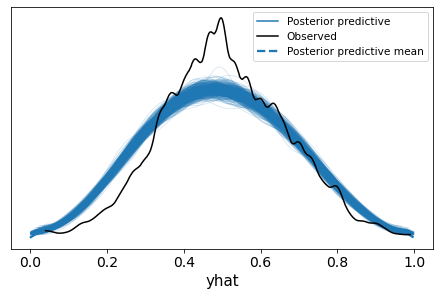

In [38]:
az.plot_ppc(az_data_bs, data_pairs={"yhat":"yhat"},num_pp_samples=500)

corr =  0.665


<AxesSubplot:xlabel='preds', ylabel='estimate'>

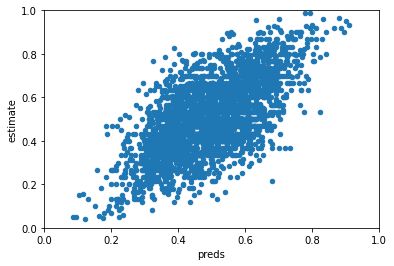

In [39]:
df_output = df
df_output["preds"] = az_data_bs.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_output.estimate, df_output.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate",xlim=(0,1), ylim=(0,1))

corr =  0.817


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

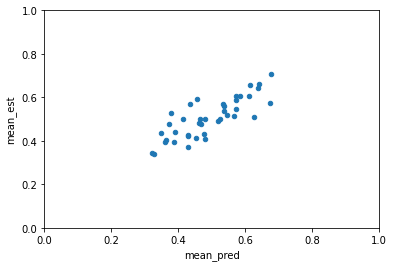

In [40]:
trial_df = df_output >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
print("corr = ", np.round(np.corrcoef(trial_df.mean_est, trial_df.mean_pred)[0,1],3))
trial_df.plot.scatter(x="mean_pred", y="mean_est",xlim=(0,1), ylim=(0,1))

# Relative Frequency model


In [41]:
def relative_freq(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])

    # population level parameters/priors
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    pi = jnp.divide(numerator, denom)

    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(pi, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(pi*k, (1-pi)*k), obs=y)
    
    return yhat

In [42]:
mcmc_rf = MCMC(NUTS(relative_freq, target_accept_prob=.80), 
               num_warmup=2000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_rf.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [43]:
# mcmc_rf.print_summary()

In [44]:
az_data_rf = make_arviz_data(mcmc_rf, relative_freq, X_data) # see model_helpers.py
az.loo(az_data_rf, scale="deviance", pointwise=True)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -1286.01    92.17
p_loo          425.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3325   99.0%
 (0.5, 0.7]   (ok)         34    1.0%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%

corr =  0.516


<AxesSubplot:xlabel='preds', ylabel='estimate'>

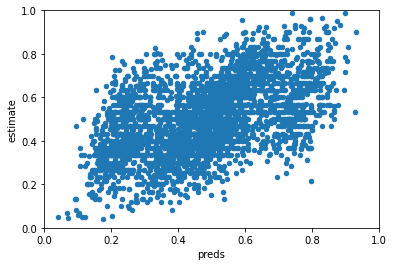

In [45]:
df_output = df
df_output["preds"] = az_data_rf.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_output.estimate, df_output.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate",xlim=(0,1), ylim=(0,1))

corr =  0.639


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

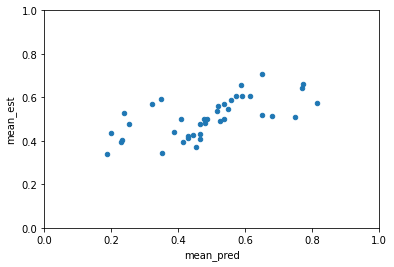

In [46]:
trial_df = df_output >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
print("corr = ", np.round(np.corrcoef(trial_df.mean_est, trial_df.mean_pred)[0,1],3))
trial_df.plot.scatter(x="mean_pred", y="mean_est",xlim=(0,1), ylim=(0,1))

# Probability theory plus noise (PT+N) model

In [102]:
def prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d):
    
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    
    p_numerator = jnp.sum(theta*X_num, axis=-1) #  = P(A & B)
    pA = jnp.sum(theta*X_A, axis=-1)
    num_or_denom = jnp.logical_or(X_A, X_denom).astype("float32")
    p_num_or_denom = jnp.sum(theta * num_or_denom , axis=-1) # = P(A or B)


    p_denom = jnp.sum(theta*X_denom, axis=-1)
    numerator = ((p_numerator)*(1-2*d)**2 + d*(1-2*d)*(pA + p_denom) + d**2)*conditional + ((1 - 2*d)*p_numerator + d)*not_conditional
    denom = ((1 - 2*d)*p_denom  + d)*conditional + p_denom*not_conditional
    
    return jnp.divide(numerator, denom) # move division to after noise is added

def PTN_complex(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    
    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfCauchy(20)) # noise parameter

    # Subject-level parameters/priors
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_delta", dist.Normal(0, 3))
        d_deltas = numpyro.sample("d_prime", dist.Normal(0, 3))
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = d_bases[subj] + d_deltas[subj] * conjdisj # this isn't requiring d_delta be +   
    d = sigmoid(d_lin)/2 # require this be below .50
    
    theta_ind = (subj*2) + cond
    theta = thetas[theta_ind,:]
    
    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d) #

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [103]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [104]:
# mcmc_ptn.print_summary()

In [105]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex, X_data) # see model_helpers.py
az.loo(az_data_ptn, scale="deviance", pointwise=True) #-3700

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -3696.13    82.15
p_loo          397.71        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3062   91.1%
 (0.5, 0.7]   (ok)        185    5.5%
   (0.7, 1]   (bad)        80    2.4%
   (1, Inf)   (very bad)   33    1.0%

Here there are some "very bad" samples, so need to run `reloo()` to fix those, following this [arviz tutorial](https://arviz-devs.github.io/arviz/user_guide/numpyro_refitting_xr_lik.html) (per this [stackoverflow post](https://stats.stackexchange.com/questions/304958/warnings-during-waic-computation-how-to-proceed)).

<AxesSubplot:xlabel='yhat'>

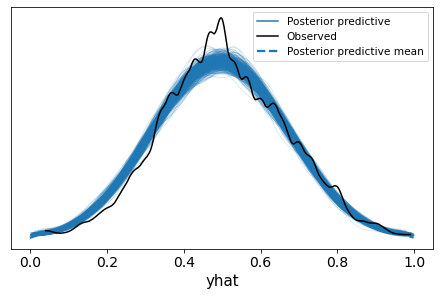

In [106]:
az.plot_ppc(az_data_ptn, data_pairs={"yhat":"yhat"},num_pp_samples=500)

corr =  0.655


<AxesSubplot:xlabel='preds', ylabel='estimate'>

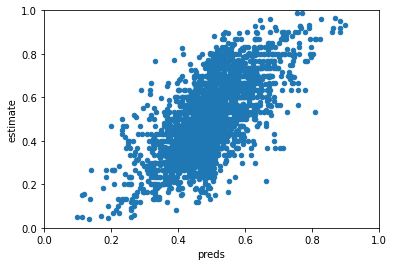

In [107]:
df_output = df
df_output["preds"] = az_data_ptn.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_output.estimate, df_output.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate", xlim=(0,1), ylim=(0,1))

corr =  0.848


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

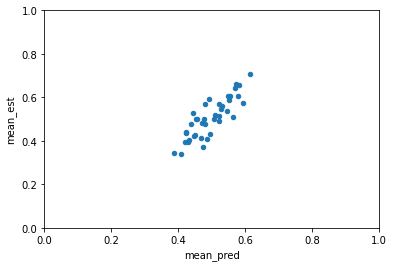

In [108]:
trial_df = df_output >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
print("corr = ", np.round(np.corrcoef(trial_df.mean_est, trial_df.mean_pred)[0,1],3))
trial_df.plot.scatter(x="mean_pred", y="mean_est", xlim=(0,1), ylim=(0,1))

# Summary and comparison of models

All three models have now been implemented as probabilistic programs, and we have obtained samples for each. According to $loo_{ic}$, PT+N model is the best (now that I have fixed my code) and the Bayesian Sampler is in second. Both of these are far better than the naive relative frequency model.

# Hierarchical Bayesian Sampler

Here's a quick implementation of a hierarchical version of the Bayesian Sampler, which requires reparameterization of some components. It samples reasonably quickly and does better in terms of $loo_{ic}$ as well as $R^2$ on the trial averages.

In [79]:
def bayesian_sampler_complex_mlm(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))

    # population level parameters/priors
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter
    beta_pop = numpyro.sample("beta_pop", dist.Normal(0, 1.72)) # roughly uniform after sigmoid()
    beta_sd = numpyro.sample("beta_sd", dist.HalfCauchy(3))
    
    N_prime_pop = numpyro.sample("N_prime_pop", dist.Normal(0,3))
    N_delta_pop = numpyro.sample("N_delta_pop", dist.Normal(0,10))
    N_prime_sd = numpyro.sample("N_prime_sd", dist.HalfCauchy(1))
    N_delta_sd = numpyro.sample("N_delta_sd", dist.HalfCauchy(1))

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        betas = numpyro.sample("beta_r", dist.Normal(0, beta_sd))
        N_deltas = numpyro.sample("N_delta_r", dist.Normal(0, N_delta_sd))
        N_primes = numpyro.sample("N_prime_r", dist.Normal(0, N_prime_sd))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    

    # sigmoid() constrains beta to [0,1]
    beta = sigmoid(beta_pop + betas[subj])
    
    # exp() needed to constrain N positive
    N_lin = N_prime_pop + N_delta_pop*not_conjdisj + N_primes[subj] + 1*N_deltas[subj] * not_conjdisj
    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    
    theta_ind = ((subj*2)+cond)
    theta = thetas[theta_ind,:]
        
    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    pi = jnp.divide(numerator, denom)
    p_bs = pi * N / (N + 2.*beta) + beta/(N + 2.*beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_bs, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_bs*k, (1-p_bs)*k), obs=y)
    
    return yhat

In [80]:
mcmc_bs_mlm = MCMC(NUTS(bayesian_sampler_complex_mlm, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=2)

mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
mcmc_bs_mlm.print_summary()

In [84]:
az_data_bs_mlm = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm, X_data) # see model_helpers.py
az.loo(az_data_bs_mlm, scale="deviance", pointwise=True)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -3812.51    81.04
p_loo          393.59        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3268   97.3%
 (0.5, 0.7]   (ok)         81    2.4%
   (0.7, 1]   (bad)        11    0.3%
   (1, Inf)   (very bad)    0    0.0%

corr =  0.673


<AxesSubplot:xlabel='preds', ylabel='estimate'>

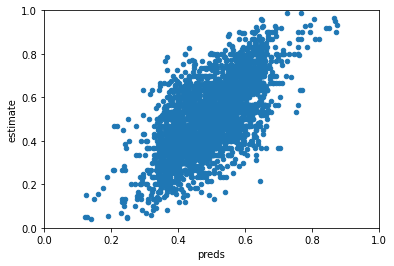

In [85]:
df_output = df
df_output["preds"] = az_data_bs_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_output.estimate, df_output.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate", xlim=(0,1), ylim=(0,1))

corr =  0.849


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

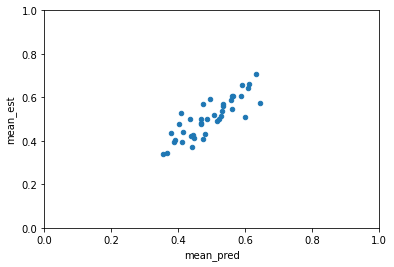

In [86]:
trial_df = df_output >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
print("corr = ", np.round(np.corrcoef(trial_df.mean_est, trial_df.mean_pred)[0,1],3))
trial_df.plot.scatter(x="mean_pred", y="mean_est",xlim=(0,1), ylim=(0,1))

# Hierarchical PT+N


In [112]:
def PTN_complex_mlm(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    X_A = jnp.stack([pA_vecs[i] for i in trial])
    conjdisj, not_conjdisj = jnp.array([is_conjdisj(i) for i in trial]), abs(1-jnp.array([is_conjdisj(i) for i in trial]))
    conditional = jnp.array([is_cond(i) for i in trial])
    not_conditional = abs(1-conditional)
    
    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    d_base_pop = numpyro.sample("d_base_pop", dist.Normal(0,3))
    d_delta_pop = numpyro.sample("d_delta_pop", dist.Normal(0,3))
    d_base_sd = numpyro.sample("d_base_sd", dist.HalfCauchy(3))
    d_delta_sd = numpyro.sample("d_delta_sd", dist.HalfCauchy(3))

    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
        d_bases = numpyro.sample("d_base_r", dist.Normal(0, d_base_sd))
        d_deltas = numpyro.sample("d_delta_r", dist.Normal(0, d_delta_sd))
        
    # Subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    d_lin = d_base_pop + d_delta_pop*conjdisj + d_bases[subj] + d_deltas[subj]*conjdisj  # they required N be at least 1, no pooling for now   
    d = sigmoid(d_lin)/2 # require this be below .50
    
    theta_ind = (subj*2) + cond
    theta = thetas[theta_ind,:]
    
    p_ptn = prob_judge_PTN(trial, theta, X_num, X_denom, X_A, d) #

    # Likelihood
    with numpyro.plate("data", len(trial)):
#         yhat = numpyro.sample("yhat", dist.Normal(p_ptn, sigma), obs = y) # wrong but replicates paper
        yhat = numpyro.sample("yhat", dist.Beta(p_ptn*k, (1-p_ptn)*k), obs=y)
    
    return yhat

In [113]:
mcmc_ptn_mlm = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.80), 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc_ptn_mlm.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 4000/4000 [04:32<00:00, 14.69it/s, 31 steps of size 1.02e-01. acc. prob=0.88] 


In [ ]:
mcmc_ptn_mlm.print_summary()

In [114]:
az_data_ptn_mlm = make_arviz_data(mcmc_ptn_mlm, PTN_complex_mlm, X_data) # see model_helpers.py
az.loo(az_data_ptn_mlm, scale="deviance", pointwise=True)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 2000 by 3360 log-likelihood matrix

             Estimate       SE
deviance_loo -3801.42    80.64
p_loo          351.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3305   98.4%
 (0.5, 0.7]   (ok)         52    1.5%
   (0.7, 1]   (bad)         3    0.1%
   (1, Inf)   (very bad)    0    0.0%

corr =  0.658


<AxesSubplot:xlabel='preds', ylabel='estimate'>

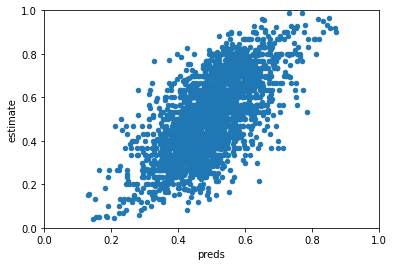

In [115]:
df_output = df
df_output["preds"] = az_data_ptn_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
print("corr = ", np.round(np.corrcoef(df_output.estimate, df_output.preds)[0,1],3))
df_output.plot.scatter(x = "preds", y = "estimate", xlim=(0,1), ylim=(0,1))

corr =  0.836


<AxesSubplot:xlabel='mean_pred', ylabel='mean_est'>

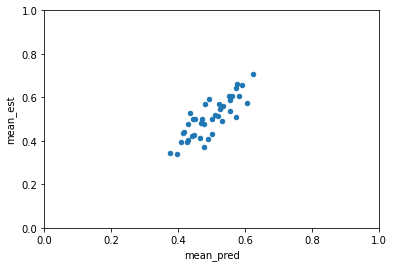

In [116]:
trial_df = df_output >> group_by(X.querytype, X.querydetail) >> summarize(mean_pred = np.mean(X.preds), mean_est = np.mean(X.estimate))
print("corr = ", np.round(np.corrcoef(trial_df.mean_est, trial_df.mean_pred)[0,1],3))
trial_df.plot.scatter(x="mean_pred", y="mean_est",xlim=(0,1), ylim=(0,1))

# Summary of hierarchical models

It's too close to call! Looks like I will need to do these for Experiment 1 as well.